In [1]:
import pandas as pd

In [172]:
filepath = '../Data/species.csv'
data = pd.read_csv(filepath, index_col=0)

series_of_interest = data.Reef_complexity

Get the years for the missing data

In [173]:
missing_years = data.loc[series_of_interest.isna(),'Year'].unique()
missing_years 

array([2013, 2014, 2015], dtype=int64)

In [167]:
import geopandas as gpd
from shapely.geometry import Point

data_na = data.loc[(data.Longitude > -80.2) & (data.Longitude < -79.9) & (data.Year.isin(missing_years))]
data_na = data_na.loc[data_na.Reef_complexity.isna()]

data_notna = data.loc[(data.Longitude > -80.2) & (data.Longitude < -79.9) & (data.Year.isin(missing_years))]
data_notna = data_notna.loc[data_notna.Reef_complexity.notna()]


# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(data_na['Longitude'], data_na['Latitude'])]
geometry_notna = [Point(xy) for xy in zip(data_notna['Longitude'], data_notna['Latitude'])]
gdf = gpd.GeoDataFrame(data_na, geometry=geometry)
gdf_notna = gpd.GeoDataFrame(data_notna, geometry=geometry_notna)

In [180]:
from shapely.geometry import box
import numpy as np

# Define the bounding box of your grid (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds

# Generate the grid
nx=10
ny=20

x_coords = list(np.linspace(-80.3, -80, num=nx))
y_coords = list(np.linspace(25.2, 27.1, num=ny))

square_size_x=x_coords[1]-x_coords[0]
square_size_y=y_coords[1]-y_coords[0]

squares = []
for x in x_coords:
    for y in y_coords:
        square = box(x, y, x + square_size_x, y + square_size_y)
        squares.append(square)

grid = gpd.GeoDataFrame({'geometry': squares})
grid_notna = gpd.GeoDataFrame({'geometry': squares})

In [181]:
# Perform spatial join
joined = gpd.sjoin(gdf, grid, how='left', op='within')

# Group by the square (grid index)
grouped = joined.groupby('index_right').size().reset_index(name='counts')

# Merge counts back with the grid
grid['counts'] = grid.index.map(grouped.set_index('index_right')['counts'])

C:\Users\GuillaumePealat\.conda\envs\coralreef\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [182]:
# Perform spatial join
joined_notna = gpd.sjoin(gdf_notna, grid_notna, how='left', op='within')

# Group by the square (grid index)
grouped_notna = joined_notna.groupby('index_right').size().reset_index(name='counts')

# Merge counts back with the grid
grid_notna['counts'] = grid_notna.index.map(grouped_notna.set_index('index_right')['counts'])

C:\Users\GuillaumePealat\.conda\envs\coralreef\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


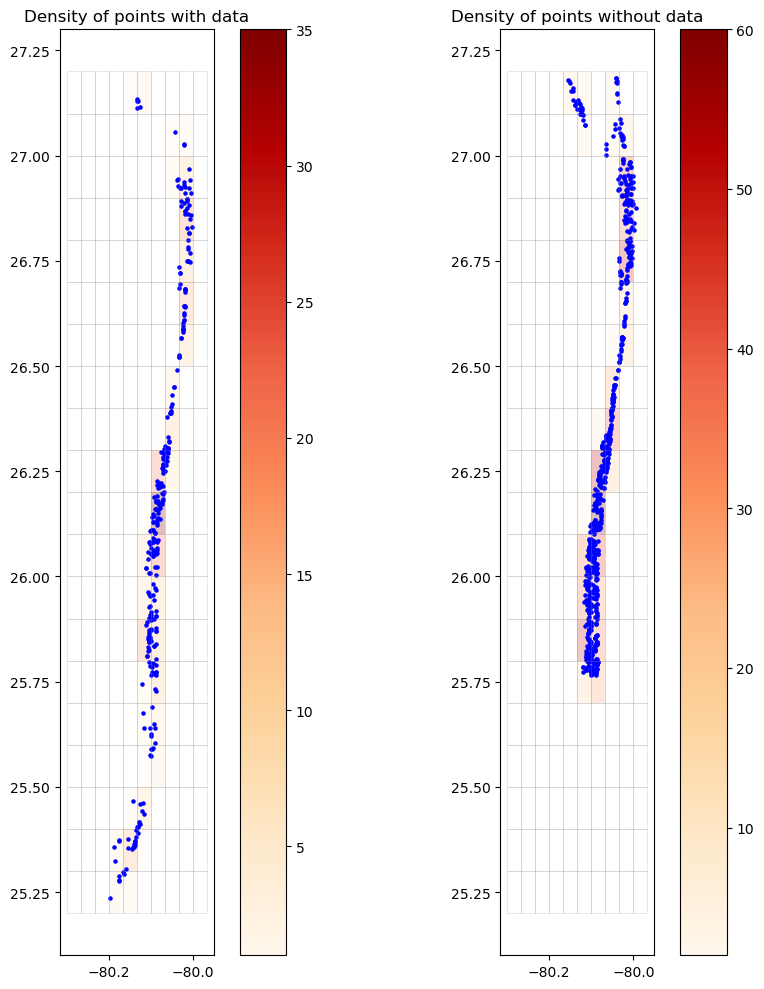

In [183]:
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))


# Plot the grid boundaries
grid_notna.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='grey', alpha=0.25)
# Plot the grid with counts
grid_notna.plot(ax=ax1, column='counts', cmap='OrRd', alpha=0.25, legend=True)
# Plot the points
gdf_notna.plot(ax=ax1, color='blue', markersize=5)
ax1.set_title('Density of points with data')

# Plot the grid boundaries
grid.boundary.plot(ax=ax2, linewidth=0.5, edgecolor='grey', alpha=0.25)
# Plot the grid with counts
grid.plot(ax=ax2, column='counts', cmap='OrRd', alpha=0.25, legend=True)
# Plot the points
gdf.plot(ax=ax2, color='blue', markersize=5)
ax2.set_title('Density of points without data')

plt.tight_layout()
plt.show()